# GEMHP (Multivariate Exponential Hawkes process)

We call $\bar{N}$ a $d$-dimensional generalized exponential marked Hawkes process (GEMHP) if its intensity process is

\[
	\lambda^i_t(\vartheta^*) = \mu_i(X_{t-}, \vartheta^*) + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} \langle A_{ij}(\vartheta^*) | e^{-sB_{ij}(\vartheta^*)}\rangle g_{ij}(x, \vartheta^*) \bar{N}^j(ds, dx), \ \ i= 1, \dots, d \nonumber,
\]

where $g_{ij} : \mathbb{X} \times \Xi \to \mathbb{R}_+, A_{ij}:  \Xi \to \mathbb{R}^{p \times p}, B_{ij} : \Xi \to \mathbb{R}^{p \times p}$ are measurable functions for $ p \in \mathbb{N}$ and the real parts of the eigenvalues of $B_{ij}(\vartheta)$ are dominated by some $r > 0$ independently of $\vartheta \in \Xi$.

## Libraries

In [1]:
import math
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import optimize, integrate
from scipy.stats import multivariate_normal, uniform, skew
import csv
from tqdm.notebook import tqdm
import itertools
import time

## Simulation

Let Generalized Elementary Excitation Process $\mathcal{E}^{ij}_t$ be

\[
    \mathcal{E}^{ij}_t = \int_{[0,t) \times \mathbb{X}} e^{-(t-s)B_{ij}} g_{ij}(x) \bar{N}^j(ds, dx)\nonumber
\]

Moreover, let $\mathcal{E}_t = \big(\mathcal{E}^{ij}_t\big)_{ij}$, $X_t$ be a mark process.
The value of the GEMHP's intensity process at time $t$ is updated based on the value of $Z_u:= (\mathcal{E}_u, X_u)$ for $t>u$ as follows:

\[
    \lambda^i_t = \mu_i + \sum_{j=1}^d \left\{ \left\langle A_{ij} \Big| e^{-(t-u)B_{ij}} \mathcal{E}^{ij}_u \right\rangle + \int_{[u,t) \times \mathbb{X}} h_{ij}(t-s, x) \bar{N}^j(ds, dx)\right\}, \ \ i = 1,\dots d. \nonumber
\]

Then, a path of the GEMHP can be simulated by using the above computation for the intensity process and Ogata's method.

In [2]:
## parameter：params = [mu, alpha, beta, m, paramsMark, initEps] (list)
### mu : d-dim Vector (np.array)
### alpha : [d, d, p]-dim Tensor (np.array)
### beta : [d, d]-dim Matrix (np.array)
### m : [d, d, d']-dim Tensor (np.array)
### paramsMark: parameter for mark density
### initEps : [d, d, p, p]-dim Tensor (np.array), the initial value of elementary excitation process

## Polynomial Type Excitation Kernel w.r.t. time
def PolyExpKernel(time, params):
    ## time : : [time, ...], len(time)-dim Vector or float, int
    ## params : all parameters
    alpha = params[1]
    dim = len(params[0])
    d_alpha = len(alpha[0,0])
    #casting
    if type(time) != np.ndarray:
        time = np.array(time).reshape(1,1)
    else:
        time = np.array(time).reshape(len(time),1)
            
    fact = np.vectorize(np.math.factorial)(np.arange(d_alpha)) # [1!, 2!, 3!,...]
    components = time**np.arange(d_alpha)/fact # Ploynomial type
    expt = components[:, :d_alpha]
    for i in range(1, d_alpha):
        exptcol = np.append(np.zeros((len(time), i)), components[:, :d_alpha-i], axis=1)
        expt = np.append(expt, exptcol, axis=1)
    expt = expt.reshape(len(time), d_alpha, d_alpha)
    
    A = np.zeros((dim, dim, d_alpha, d_alpha))
    for i in range(dim):
        for j in range(dim):
            A[i,j,0] = alpha[i,j]*fact
    
    return A, expt
## Square impact from mark
def gSquare(mark, params):
    ## mark : [x, ...], [len(mark), d']-dim matrix
    ## params_m : m_{i,j,l}, [d, d, d']-dim Tensor     
    _dim = len(params[0])
    m = params[3]
    if mark.ndim==1: mark = mark.reshape(1, len(mark)) # casting
    return 1+(m@(mark.T**2)).transpose(2,0,1)
## Linear impact from mark
def gLinear(mark, params):
    ## mark : [x, ...], [len(mark), d']-dim matrix
    ## params_m : m_{i,j,l}, [d, d, d']-dim Tensor     
    _dim = len(params[0]) 
    m = params[3]
    if mark.ndim==1: mark = mark.reshape(1, len(mark)) # casting
    _mark = np.append(np.ones((len(mark), 1)), mark, axis=1) # Add Constant Term
    return (m@_mark.T).transpose(2,0,1)

## General Excitation Kernel
def Excitor(Eps, JumpDim, mark, params, kernel = PolyExpKernel, g = gSquare):
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## JumpDim : Dimension of the last jump
    ## mark : [x, ...], [len(mark), d']-dim matrix or d'-dim Vector
    ## params : all parameters
    ## kernel : Excitation function for time
    ## g : Excitation function for mark
    mu = params[0]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    JumpDim = int(JumpDim) # casting
    _intensity = mu.copy()
    _newEps = Eps.copy()
    _A, _exp0 = PolyExpKernel(0, params)
    _exp0 = _exp0[0]
    
    _g = g(mark, params)[0]
    
    for i in range(dim):
            _newEps[i,JumpDim-1] += _exp0*_g[i,JumpDim-1]
            for j in range(dim):
                _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps
def Attenuator(delta, Eps, params, kernel = PolyExpKernel):
    ## delta : time interval
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## prarms : params
    ## kernel : Excitation function for time
    beta = params[2]
    dim = len(params[0])
    d_alpha = len(params[1][0,0])
    
    _intensity = mu.copy()
    _newEps = np.zeros((dim, dim, d_alpha, d_alpha))
    _A, _expt = PolyExpKernel(delta, params)
    _expt = _expt[0]

    for i in range(dim):
        for j in range(dim):
            _newEps[i,j] = np.exp(-beta[i,j]*delta)*_expt@Eps[i,j]
            _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps          
    
## Examples of markDist
def markMultiNormal(preValue, paramsMark, JumpDim, size=1, markDim=1):
    mean = paramsMark[0]
    cov = paramsMark[1]
    return np.random.multivariate_normal(mean, cov, (size, markDim))
def markMultiUnif(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _low = paramsMark[0]
    _high = paramsMark[1]
    return np.random.uniform(_low, _high, (size, markDim))
def markMultiDirichlet(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _alpha = paramsMark[0]
    return np.random.dirichlet(_alpha, size)

## Conditional Expected Size of Jump by Monte Carlo Simulation for the judge of Stability
## IID Mark Case, (Spectral radius of Phi) < 1 → Stable
def ComputeG(x, params, markDist, g = gSquare, MC = 100000, markDim=1):
    dim = len(params[0])
    _G = np.zeros((dim, dim))
    for j in range(dim):
        sample = markDist(x, params[4], JumpDim=j, size=MC, markDim=markDim)
        g_j = g(sample, params)
        for i in range(dim):
            _G[i,j] = np.sum(g_j[:,i,j])/MC
    return _G
def ComputeB(params):
    ## params : all parameters
    _beta = params[2]
    dim = len(params[0])
    d_alpha = len(params[1][0,0])
    _B = np.zeros((dim, dim, d_alpha, d_alpha))
    _M = np.zeros((d_alpha, d_alpha))
    
    for i in range(d_alpha):
        for j in range(d_alpha):
            if j==i+1: _M[i,j] = 1
    for i in range(dim):
        for j in range(dim):
            _B[i,j] = _beta[i,j]*np.eye(d_alpha) - _M
    return _B
def Phi(x, params, dims, markDist = markMultiUnif, kernel = PolyExpKernel, g =gSquare, MC = 10000):
    dim, _, _, markDim = dims
    
    _A, _ = kernel(0, params)
    _B = ComputeB(params)
    _G = ComputeG(x, params, markDist, g, MC, markDim)
    _Phi = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            _invB = np.linalg.inv(_B[i,j])
            _Phi[i,j] = np.sum(_A[i,j]*_invB)*_G[i,j]
    return _Phi

# Sum of the max increment of deac dimensional Kernel 
def MaxKernelUnifMark(params, dims, JumpDim, kernel=PolyExpKernel):
    _Eps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
    InitIntensity, _Eps = Excitor(_Eps, JumpDim, np.array([1.]*dims[3]), params, kernel) # Unif mark <= 1
    MaxInc = 0.
    for i in range(len(params[0])):
        seq = np.arange(0, 10, 0.1)
        y = np.zeros(len(seq))
        for n in range(len(seq)):
            y[n] = Attenuator(seq[n], _Eps, params, kernel)[0][i]
        MaxInc += np.max(y)-InitIntensity[i]
    return MaxInc 
############################################################################
############################################################################

## Simulate Hawkes time series with Ogata's method
def simulateGEMHP(params, t_max, dims, markDist = markMultiUnif, kernel = PolyExpKernel, g = gSquare):
    _params = params.copy()
    MaxInc = MaxKernelUnifMark(_params, dims, 0, kernel) # JumpDimに依存したりMarkの上限が1でない場合は要修正
    dim, _, d_mark, markDim = dims
    paramsMark, initEps = _params[4], _params[5]
    arrivals = np.array([[0,1]]) # each jump times (t_{i,0} = 0 for all i)
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)
    x = np.zeros(d_mark)
    marks = np.zeros((1,d_mark+1)) # each marks
    delta = 0 # last jump time interarrival
    t = 0 # last jump time

    ### Case: first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    intensity, Eps = Attenuator(0, initEps, _params)
    lambda_bar = np.sum(intensity)+MaxInc
    delta = -np.log(np.random.uniform())/lambda_bar
    t = delta
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals, marks[1:]

    # Calculate now intensity at t = delta- (※ not jump yet!)
    intensity, Eps = Attenuator(delta, Eps, _params, kernel)

    ## Searching for which dimension a jump is occuring in
    D = np.random.uniform()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1 # JumpDim
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        x = markDist(x, paramsMark, k, markDim=markDim)
        marks = np.append(marks, [np.append(x[0],k)], axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0: 
            intensity, Eps = Excitor(Eps, k, x, _params, kernel, g)
        lambda_bar = np.sum(intensity)+MaxInc
        delta = -np.log(np.random.uniform())/lambda_bar
        t = t + delta
        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals, marks[1:]

        # calculate now intensity at t = t + s-
        intensity, Eps = Attenuator(delta, Eps, _params, kernel)

        ## Searching for which dimension a jump is occuring in
        D = np.random.uniform()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
            x = markDist(x, paramsMark, k, markDim=markDim)
            marks = np.append(marks, [np.append(x[0],k)], axis=0)
        else:# there are no jumps
            k = 0

## QMLE

The quasi log-likelihood function as the objective functions for the GEMHP:

\[
    l_T(\vartheta) = \sum_{i=1}^d \left\{ \int_0^T \log \lambda^i(t, \vartheta)N^i(dt) - \int_o^T \lambda^i(t, \vartheta)dt + \int_{[0,T] \times \mathbb{X}} \log q^i(s, x, \vartheta) \bar{N}^i(ds, dx) \right\} 
    =: \sum_{i=1}^d \left\{ \mathbb{A}^i_T(\vartheta) + \mathbb{B}^i_T(\vartheta) + \mathbb{C}^i_T(\vartheta) \right\} \nonumber
\]

Let $\tau^i_n$ be the $n$-th jump of $N^i$. 
For multivariate exponential Hawkes process, we can write

\[
    \mathbb{A}^i_T(\vartheta)
    = \sum_{n=1}^{N^i_T} \log \left( \mu_i + \sum_{j=1}^d \sum_{\tau^j_m < \tau^i_n} \alpha_{ij}  e^{-(\tau^i_n - \tau^j_m)\beta_{ij}} \right), \nonumber
\]

\[
    \mathbb{B}^i_T(\vartheta) = -\mu_i T + \sum_{j=1}^d \sum_{n=1}^{N^j_T} \sum_{m=1}^{n-1} \frac{\alpha_{ij}}{\beta_{ij}} \big( e^{-(\tau^j_n - \tau^j_m)\beta_{ij}} - e^{-(\tau^j_{n-1} - \tau^j_m)\beta_{ij}} \big), \nonumber
\]


\[
    \mathbb{C}^i_T(\vartheta) = 0. \nonumber
\]

Then, we can define the quasi maximum likelihood estimator (QMLE) $\tilde{\vartheta}_T$ as a quantity satisfying

\[
	\tilde{\vartheta}_T = \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big)  \in argmax_{\vartheta \in \Xi} l_T(\vartheta). \nonumber
\]

In [3]:
## Params Cast w.r.t. Mark
def markMultiNormalToVector(paramsMark):
    mean = paramsMark[0]
    cov = paramsMark[1].reshape(1, -1)[0]
    return np.concatenate([mean, cov])
def markMultiNormalToList(paramsMarkVector, MarkDim):
    mean = paramsMarkVector[:MarkDim]
    cov = paramsMarkVector[MarkDim:].reshape(MarkDim,MarkDim)
    return [mean, cov]
## Params Cast w.r.t. Hawkes
def ParamsToVector(params, paramsMarkToVector = markMultiNormalToVector):
    ## Initial Eps is ignored
    mu = params[0]
    alpha = params[1].reshape(1, -1)[0]
    beta = params[2].reshape(1, -1)[0]
    m = params[3].reshape(1, -1)[0]
    if len(params)==5: 
        paramsMark = paramsMarkToVector(params[4])
        return np.concatenate([mu, alpha, beta, m, paramsMark])
    else:
        return np.concatenate([mu, alpha, beta, m])  
def ParamsToList(paramsVector, dims, paramsMarkToList = markMultiNormalToList, m = None, TrueParamsMark = None, initEps = None):
    dim, d_alpha, d_mark, MarkDim = dims
    preID, ID = 0, dim
    mu = paramsVector[preID:ID]
    preID, ID = ID, ID + dim*dim*d_alpha
    alpha = paramsVector[preID:ID].reshape(dim, dim, d_alpha)
    preID, ID = ID, ID + dim*dim
    beta = paramsVector[preID:ID].reshape(dim, dim)
    if m == None:
        m = np.zeros((dim, dim, d_mark))
    if paramsMark == None:
        paramsMarkToList(paramsVector[ID:], MarkDim)
    if initEps == None:
        initEps = np.zeros((dim, dim, d_alpha, d_alpha)) # if initEps = None, it is 0
    return [mu, alpha, beta, m, paramsMark, initEps]
## Examples of markDensity
def markMultiNormalPDF(mark, preValue, paramsMark, JumpDim):
    mean = paramsMark[0]
    cov = paramsMark[1]
    return multivariate_normal.pdf(mark, mean, cov)
def markMultiUnifPDF(mark, preValue, paramsMark, JumpDim):
    low = paramsMark[0]
    high = paramsMark[1]
    return uniform.pdf(mark, low, high)

# Loglikelihood for No Mark Process
def kernel_free(t, s, beta):
    kernel = np.exp(-beta*(t - s))
    return kernel
def LogLikelihood(paramsVector, args):
    arrivals, marks, dims, paramsMark = args
    _mu, _alpha, _beta, _m, _paramsMark, _initEps = ParamsToList(paramsVector, dims)
    dim, d_alpha, d_mark, MarkDim = dims
    t_max = arrivals[-1][0]

    loglik = []
    time = []
    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)
        for n in range(len(time[i]))[:-1]:
            intensity = _mu[i]
            for j in range(dim):
                num = np.sum(time[j][:]<time[i][n])
                dtime = time[i][n]-time[j][:num]
                exptB = np.exp(-_beta[i][j]*dtime)
                intensity += _alpha[i][j][0]*np.sum(exptB)          
            Ai += np.log(intensity)
        for j in range(dim):
            Bi += (-1)*(_alpha[i][j][0]/_beta[i][j])*np.sum(kernel_free(t_max, time[j][:-1], _beta[i][j])-1)
        loglik.append(Ai - (_mu[i]*t_max + Bi))
    return -np.sum(loglik)

In [4]:
def Gradient(f, x, args, delta=1.0e-10):
    _grad = np.zeros(len(x))
    for i in range(len(x)):
        xh = x.copy()
        xh[i] += delta
        _grad[i] = (f(xh, args) - f(x, args))/delta
    return _grad
def GEMHP_Hist(data, dims, title="Histgram", SavePath=""):
    FigColNum = 1+dims[0]*dims[1]+dims[0]+dims[0]*dims[2]
    fig = plt.figure(figsize=(20,20/FigColNum))
    plt.subplots_adjust(top=0.8, bottom = 0.2, hspace=0.3, wspace=0.2)
    gs = gridspec.GridSpec(dims[0], FigColNum)

    for i in range(dims[0]):
        ax = fig.add_subplot(gs[i,0])
        plt.subplot(gs[i,0])
        MuData = np.array(data).T[i]
        ax.hist(MuData, bins=25, color="green")
        plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=20)
        ax.grid()
    for i in range(dims[0]):
        for j in range(dims[0]):
            for k in range(dims[1]):
                ax = fig.add_subplot(gs[i,1+dims[1]*j+k])
                plt.subplot(gs[i,1+dims[1]*j+k])
                AlphaData = np.array(data).T[dims[0]+dims[0]*dims[1]*i+dims[1]*j+k]
                ax.hist(AlphaData, bins=25, color="red")
                plt.xlabel(r'$ \alpha_{%d%d%d} $' %((i+1), (j+1), (k+1)), fontsize=20)
                ax.grid()        
    for i in range(dims[0]):
        for j in range(dims[0]):            
            ax = fig.add_subplot(gs[i,1+dims[0]*dims[1]+j])
            plt.subplot(gs[i,1+dims[0]*dims[1]+j])
            BetaData = np.array(data).T[dims[0]+dims[0]**2*dims[1]+dims[0]*i+j]
            ax.hist(BetaData, bins=25, color="blue")
            plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=20)
            ax.grid()      
    for i in range(dims[0]):
        for j in range(dims[0]):
            for k in range(dims[2]):
                ax = fig.add_subplot(gs[i,1+dims[0]*dims[1]+dims[0]+dims[2]*j+k])
                plt.subplot(gs[i,1+dims[0]*dims[1]+dims[0]+dims[2]*j+k])
                MData = np.array(data).T[dims[0]+dims[0]**2*dims[1]+dims[0]**2+dims[0]*dims[2]*i+dims[2]*j+k]
                ax.hist(MData, bins=25, color="purple")
                plt.xlabel(r'$ m_{%d%d%d} $' %((i+1), (j+1), (k+1)), fontsize=20)
                ax.grid()  
        
    fig.suptitle(title, fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
    return None

# P-O Estimator

In the P-O method, the estimation is done in three steps.


Step 1 : We obtain the first estimator of $\vartheta$ by

\[
    \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big) = argmin_{\vartheta \in \Xi} l_T(\vartheta).\nonumber
\]
        
Step 2 : We obtain the second estimator of $(\theta^0, \nu^0)$ by

\[
	\big( \hat{\theta}^{0,(q)}_T, \hat{\nu}^{0,(q)}_T \big) = argmin_{ (\theta^0, \nu^0 ) \in \bar{\Theta}^0 \times \bar{\mathcal{N}}^0} Q^{(q)}_T(\theta^0, \nu^0).\nonumber
\]
        
Step 3 : We obtain the third estimator of $\vartheta$ by

\[
    \big( \check{\theta}^0_T, \check{\theta}^1_T, \check{\nu}^0_T, \check{\nu}^1_T \big) = argmin_{ \vartheta \in \hat{\Theta}^0_T \times \Theta^1 \times \hat{\mathcal{N}}^0_T \times \mathcal{N}^1} l_T(\vartheta),\nonumber
\]
        
where $\hat{\Theta}^0_T = \big\{\theta^0 \in \bar{\Theta}^0 \big| \theta^0_j = 0, j \in \hat{\mathcal{J}}^0_T \big\}, \hat{\mathcal{J}}^0_T = \big\{ j = 1, \dots, p_0 \big| \hat{\theta}^{0, (q)}_j = 0 \big\}, \hat{\mathcal{N}}^0_T = \big\{\nu^0 \in \bar{\mathcal{N}}^0 \big| \nu^0_j = 0, j \in \hat{\mathcal{K}}^0_T \big\}$ and $\hat{\mathcal{K}}^0_T = \big\{ j = 1, \dots, n_0 \big| \hat{\nu}^{0, (q)}_j = 0 \big\}$.
The objective function $Q^{(q)}_T(\theta^0, \nu^0)$ is constructed by using the first estimators $\tilde{\theta}^0_T, \tilde{\nu}^0_T$ as below.

\[
	Q^{(q)}_T(\theta^0, \nu^0) = \sum_{j=1}^{p_0} \Big( \big( \theta^0_j - \tilde{\theta}^0_j \big)^2 + \kappa^{\theta}_j | \theta_j |^q \Big) +  \sum_{j=1}^{n_0} \Big( \big( \nu^0_j - \tilde{\nu}^0_j \big)^2 +\kappa^{\nu}_j  | \nu_j |^q \Big) \nonumber
\]

where $q \in (0, 1],  \kappa^{\theta}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\theta}_j + T^{-\frac{1}{2}} \big|^{\gamma}},  \kappa^{\nu}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\nu}_j + T^{-\frac{1}{2}} \big|^{\gamma}}, \gamma > -(1-q)$ and $a \in (1-q-\gamma, 0)$.

In [5]:
# Step. 1. : Estimate MLE by LogLikelihood
# Step. 2.a. : Extract possibly zero components from MLE by LSAParams
# Step. 2.b. : Estimate LSAE by LSA
# Step 3.a. : Extract zero components from LSAE by LSAParams
# Step 3.b : Estimate P-O by ElimLogLikelihood

# Extract possibly zero components (mu, alpha) for ElimZeroParams
def LSAParams(paramsVector, dims, bounds):
    dim, d_alpha, d_mark, markDim = dims
    LSAParamsVector = paramsVector[:dim+dim**2]
    low_bd = bounds[0][:dim+dim**2]
    up_bd = bounds[1][:dim+dim**2]
    LSABounds = [low_bd, up_bd]
    return LSAParamsVector, LSABounds
# Reconstruct full parameter from LSAParamsVector.
def ReconstLSAParams(LSAParamsVector, paramsVector, dims):
    dim, d_alpha, d_mark, markDim = dims
    ParamsVector = np.concatenate([LSAParamsVector[:dim+dim**2], paramsVector[dim+dim**2:]])
    return ParamsVector
# Eliminate zero components
def ElimZeroParams(paramsVector, bounds):
    nonZeroId = paramsVector!=0
    elimParamsVector = paramsVector[nonZeroId]
    low_bd = bounds[0][nonZeroId].tolist()
    up_bd = bounds[1][nonZeroId]
    elimBounds = [low_bd, up_bd]
    return elimParamsVector, nonZeroId, elimBounds
# Reconstruct full parameter from elimParamsVector.
def ReconstZeroParams(elimParamsVector, nonZeroId):
    paramsVector = np.array(nonZeroId, float) # Zero params are zero
    paramsVector[nonZeroId] = elimParamsVector
    return paramsVector

# Objective function (Least Square Approximation)
def LSA(zeroParamsVector, args): 
    zeroPreEstVector, dims, t_max, gamma, a, q = args # where zeroPreEstVector = LSAParams(preEstVector, dims)
    kappa = t_max**(-(1+a)/2)*(zeroPreEstVector+1.0e-5*t_max**(-1/2))**(-gamma) # 罰則項係数．
    lsa = np.sum((zeroParamsVector-zeroPreEstVector)**2 + kappa*zeroParamsVector**q)
    return lsa
# Objective function (LogLikelihood)
def ElimLogLikelihood(elimParamsVector, args):
    arrivals, marks, dims, paramsMark, nonZeroId = args
    paramsVector = ReconstZeroParams(elimParamsVector, nonZeroId)
    return LogLikelihood(paramsVector, [arrivals, marks, dims, paramsMark])

# Step1: LSE -> Step2: LSA -> Step3: QMLE
# bounds1, bounds2はlistで渡し，full paramsに対して定義しておく．Step2ではbounds1を，Step3ではbounds2を間引いて使用する．
def PO(args, x0, bounds, method='L-BFGS-B', gamma=1., a=0.5, q=1., text=True):
    arrivals, marks, dims, paramsMark = args
    Bounds = optimize.Bounds(bounds[0], bounds[1])
    mle = optimize.minimize(fun=LogLikelihood, x0=x0, args=args, method='L-BFGS-B', bounds=Bounds)
    
    LSAMLEVector, LSABounds = LSAParams(mle.x, dims, bounds)
    LSABounds = optimize.Bounds(LSABounds[0], LSABounds[1])
    argsLSA = [LSAMLEVector, dims, arrivals[-1][0], gamma, a, q]
    lsae = optimize.minimize(fun=LSA, x0=LSAMLEVector, args=argsLSA, method='L-BFGS-B', bounds=LSABounds)
    
    LSAVector = ReconstLSAParams(lsae.x, mle.x, dims)
    elimLSAVector, nonZeroId, elimBounds = ElimZeroParams(LSAVector, bounds)
    elimBounds = optimize.Bounds(elimBounds[0], elimBounds[1])
    argsElimMLE = [arrivals, marks, dims, paramsMark, nonZeroId]
    elimpoe = optimize.minimize(fun=ElimLogLikelihood, x0=elimLSAVector, args=argsElimMLE, method='L-BFGS-B', bounds=elimBounds)
    
    if text:
        print(mle, '\n\n', lsae, '\n\n', elimpoe)   
    
    poe = ReconstZeroParams(elimpoe.x, nonZeroId)

    return poe, mle.x

## Multivariate exponential Hawkes process

We consider the multivariate exponential Hawkes process $N_t = (N^1_t, \dots, N^d_t)$ whose intensity is

\[
	\lambda^i_t(\vartheta^*) = \mu_i + \sum_{j=1}^d \int_{[0,t)} \alpha_{ij}e^{-(t-s)\beta_{ij}} N^j(ds) \bigg|_{\vartheta = \vartheta^*}, \quad i = 1,\dots d, \nonumber
\]

where $\vartheta = \big(\{\alpha_{ij}\}_{ij}, \{\mu_i\}_i, \{\beta_{ij}\}_{ij} \big) \in \Xi \subset \mathbb{R}_+^{d^2} \times \mathbb{R}_{>0}^{d+d^2}$ is a parameter and $\vartheta^*= \big( \{\alpha^*_{ij}\}_{ij}, \{\mu^*_i\}_i, \{\beta^*_{ij}\}_{ij} \big) \in \Xi$ is the true value.

### Example : 3-dim exponential Hawkes process
Let $N_t = (N^1_t ,N^2_t, N^3_t)$ be a $3$-dimensional exponential Hawkes process with the following parameters:

\[
	\mu^* = (0.2, 0.1, 0.1), \ \
	\alpha^* = \left(
		\begin{array}{ccc}
			0.0& 0.2& 0.0\\
			0.2& 0.1& 0.4\\
			0.0& 0.0& 0.2
		\end{array}
		\right), \ \
	\beta^* = \left(
		\begin{array}{ccc}
			*& 0.9& *\\
	 		0.5& 1.2& 0.6\\
	 		*& *& 0.7
		\end{array}
		\right), \nonumber
\]

where $*$ means a non-definite value.

In [6]:
## e.g.1 Setting
np.random.seed(0)

dims = [3, 1, 1, 1] # dim, d_alpha, d_mark (= d, p, d') , dim of mark
mu = np.array([0.2, 0.1, 0.1], dtype=float)
alpha = np.array([[[0], [0.2], [0]], [[0.2], [0.1], [0.4]], [[0], [0], [0.2]]], dtype=float)
beta = np.array([[1, 0.9, 1], [0.5, 1.2, 0.6], [1, 1, 0.7]], dtype=float)
m = np.zeros((dims[0], dims[0], dims[2]))
paramsMark = [np.array([0], dtype=float), np.array([[1]], dtype=float)] # Unif dist
initEps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
params = [mu, alpha, beta, m, paramsMark, initEps]
paramsVector = ParamsToVector(params)

t_max = 3000 # Observed Time
low_bd, up_bd = np.repeat(0., len(paramsVector)), np.repeat(1.e+10, len(paramsVector))
low_bd[:dims[0]] += 1.0e-5
low_bd[dims[0]+dims[0]**2:] += 1.0e-5
bounds = [low_bd, up_bd] # Bounds for parameter

## Monte Calro Simulation
MC = 300 # Number of Monte Calro
mleList = []
poeList = []
mleErrorList = []
poeErrorList = []
cnt = 0
pbar = tqdm(total=MC)
while cnt < MC:
    arrivals, marks = simulateGEMHP(params, t_max, dims)
    args = [arrivals, marks, dims, paramsMark]
    poe, mle = PO(args, paramsVector, bounds, text=False)
    print(len(arrivals))
    print(np.round(mle[:-9],2))
    print(np.round(poe[:-9],2))
    mleList.append(mle[:-9])
    poeList.append(poe[:-9])
    mleErrorList.append(np.sqrt(t_max)*(mle - paramsVector)[:-9])
    poeErrorList.append(np.sqrt(t_max)*(poe - paramsVector)[:-9])
    pbar.update(1)
    cnt += 1

  0%|          | 0/300 [00:00<?, ?it/s]

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in reciprocal


2175
[0.2  0.08 0.11 0.   0.25 0.01 0.21 0.07 0.37 0.   0.   0.24 1.   1.2
 1.02 0.51 0.52 0.65 1.   0.99 0.96]
[0.21 0.08 0.11 0.   0.25 0.   0.21 0.07 0.37 0.   0.   0.24 1.   1.2
 1.02 0.51 0.52 0.65 1.   0.99 0.96]
2216
[0.19 0.07 0.09 0.   0.29 0.   0.2  0.15 0.44 0.   0.01 0.19 1.   1.01
 1.01 0.49 1.7  0.59 1.   0.18 0.68]
[0.19 0.07 0.1  0.   0.29 0.   0.2  0.15 0.44 0.   0.   0.19 1.   1.01
 1.01 0.49 1.7  0.59 1.   0.18 0.63]
2121
[0.21 0.09 0.1  0.   0.2  0.   0.2  0.05 0.38 0.   0.09 0.26 1.   1.26
 1.   0.49 0.91 0.6  1.   7.81 0.91]
[0.21 0.09 0.1  0.   0.2  0.   0.2  0.05 0.38 0.   0.09 0.26 1.   1.26
 1.   0.49 0.91 0.6  1.   7.81 0.91]
2145
[0.2  0.13 0.09 0.   0.19 0.   0.16 0.16 0.37 0.02 0.   0.16 1.   0.9
 1.   0.46 2.1  0.74 0.72 1.   0.56]
[0.2  0.13 0.1  0.   0.19 0.   0.16 0.16 0.37 0.   0.   0.16 1.   0.9
 1.   0.46 2.1  0.74 0.72 1.   0.55]
2259
[0.21 0.1  0.09 0.   0.2  0.04 0.19 0.16 0.46 0.   0.   0.21 1.   1.17
 0.34 0.47 2.08 0.68 1.   1.   0.65]
[0.21 0

2158
[0.18 0.08 0.07 0.01 0.21 0.01 0.15 0.16 0.38 0.   0.   0.23 0.87 0.81
 1.15 0.36 1.08 0.68 1.   0.05 0.82]
[0.18 0.08 0.09 0.   0.22 0.   0.15 0.16 0.38 0.   0.   0.22 0.87 0.81
 1.15 0.36 1.07 0.67 1.   0.05 0.75]
2159
[0.2  0.11 0.09 0.   0.22 0.   0.15 0.13 0.4  0.   0.01 0.21 1.   0.9
 0.89 0.52 1.44 0.59 1.   0.43 0.7 ]
[0.2  0.11 0.09 0.   0.22 0.   0.15 0.13 0.4  0.   0.   0.21 1.   0.9
 0.89 0.52 1.44 0.59 1.   0.43 0.67]
2203
[0.21 0.09 0.1  0.   0.13 0.05 0.2  0.1  0.35 0.11 0.   0.14 1.   0.74
 1.29 0.51 0.91 0.57 5.11 1.   0.57]
[0.21 0.09 0.1  0.   0.13 0.05 0.2  0.1  0.35 0.11 0.   0.14 1.   0.73
 1.29 0.51 0.91 0.57 5.11 1.   0.57]
2269
[0.18 0.09 0.09 0.03 0.23 0.03 0.22 0.11 0.42 0.   0.04 0.25 0.98 0.94
 0.98 0.58 1.07 0.51 1.01 1.02 1.01]
[0.18 0.09 0.09 0.   0.24 0.   0.22 0.11 0.42 0.   0.04 0.25 0.98 0.91
 0.98 0.58 1.07 0.51 1.01 1.02 1.01]
2175
[0.17 0.08 0.09 0.01 0.14 0.   0.22 0.13 0.38 0.   0.01 0.2  0.12 0.64
 1.   0.44 2.61 0.53 1.   0.85 0.67]
[0.18

2105
[0.2  0.08 0.09 0.   0.2  0.   0.2  0.03 0.49 0.   0.04 0.14 1.   1.27
 1.   0.42 0.56 0.66 1.   0.79 0.68]
[0.2  0.08 0.09 0.   0.2  0.   0.2  0.   0.49 0.   0.04 0.14 1.   1.27
 1.   0.4  0.56 0.63 1.   0.79 0.68]
2298
[1.900e-01 9.000e-02 1.100e-01 1.000e-02 1.900e-01 3.900e-01 1.600e-01
 8.000e-02 4.100e-01 0.000e+00 0.000e+00 2.200e-01 1.220e+00 8.900e-01
 3.025e+01 4.700e-01 5.400e-01 5.700e-01 1.000e+00 1.000e+00 7.400e-01]
[ 0.19  0.09  0.11  0.    0.2   0.39  0.16  0.08  0.41  0.    0.    0.22
  1.22  0.89 30.25  0.47  0.54  0.57  1.    1.    0.74]
2309
[0.19 0.1  0.1  0.   0.27 0.   0.26 0.09 0.36 0.   0.   0.21 1.   1.08
 1.   0.63 0.75 0.65 1.   1.   0.66]
[0.19 0.1  0.1  0.   0.27 0.   0.26 0.09 0.36 0.   0.   0.21 1.   1.08
 1.   0.63 0.75 0.65 1.   1.   0.66]
2201
[0.2  0.12 0.09 0.   0.23 0.   0.27 0.11 0.31 0.   0.   0.22 1.   1.3
 1.   0.66 2.04 0.5  1.   1.01 0.68]
[0.2  0.12 0.09 0.   0.23 0.   0.27 0.11 0.3  0.   0.   0.22 1.   1.3
 1.   0.66 2.04 0.5  1.   1.

2227
[ 0.2   0.1   0.1   0.    0.17  0.    0.2   0.15  0.4   0.12  0.11  0.15
  1.    0.78  1.    0.6   1.16  0.61 13.28 29.81  0.49]
[ 0.2   0.1   0.1   0.    0.17  0.    0.2   0.15  0.4   0.12  0.11  0.15
  1.    0.77  1.    0.6   1.16  0.61 13.28 29.81  0.49]
2345
[0.18 0.11 0.1  0.02 0.15 0.   0.21 0.1  0.47 0.   0.   0.27 0.51 0.64
 1.   0.53 1.69 0.63 1.   1.   0.83]
[0.19 0.11 0.1  0.   0.15 0.   0.21 0.1  0.47 0.   0.   0.27 0.51 0.63
 1.   0.53 1.69 0.63 1.   1.   0.83]
2302
[0.21 0.09 0.11 0.   0.2  0.   0.19 0.19 0.36 0.03 0.   0.22 1.   0.98
 1.   0.45 2.06 0.54 2.19 1.28 1.09]
[0.21 0.09 0.12 0.   0.2  0.   0.19 0.19 0.36 0.   0.   0.21 1.   0.99
 1.   0.45 2.06 0.54 2.19 1.28 1.01]
2356
[0.2  0.09 0.1  0.   0.24 0.02 0.25 0.17 0.34 0.   0.03 0.21 1.   1.09
 0.18 0.49 3.71 0.46 1.   2.65 0.79]
[0.21 0.09 0.1  0.   0.23 0.   0.25 0.17 0.34 0.   0.   0.21 1.   0.98
 0.18 0.49 3.7  0.46 1.   2.65 0.77]
2268
[0.21 0.08 0.09 0.01 0.22 0.   0.2  0.15 0.42 0.   0.01 0.21 1.43 1.1

2237
[0.18 0.08 0.1  0.02 0.2  0.03 0.17 0.16 0.39 0.   0.   0.22 0.98 0.78
 0.63 0.42 2.08 0.51 1.   1.02 0.72]
[0.18 0.08 0.1  0.   0.21 0.   0.17 0.16 0.39 0.   0.   0.22 0.98 0.77
 0.63 0.42 2.08 0.51 1.   1.02 0.72]
2150
[0.2  0.08 0.1  0.   0.18 0.   0.21 0.13 0.41 0.   0.   0.14 1.   0.91
 1.   0.46 1.34 0.58 1.   1.   0.5 ]
[0.2  0.08 0.1  0.   0.18 0.   0.21 0.13 0.41 0.   0.   0.14 1.   0.91
 1.   0.46 1.34 0.58 1.   1.   0.5 ]
2214
[0.21 0.09 0.1  0.   0.18 0.02 0.18 0.11 0.32 0.   0.   0.25 1.   0.92
 1.   0.4  0.97 0.59 1.   1.   0.87]
[0.21 0.09 0.1  0.   0.18 0.   0.18 0.11 0.32 0.   0.   0.25 1.   0.92
 1.   0.4  0.97 0.59 1.   1.   0.87]
2315
[0.2  0.1  0.08 0.   0.27 0.   0.17 0.09 0.41 0.1  0.01 0.25 1.   1.15
 1.08 0.43 0.87 0.59 8.19 0.66 0.7 ]
[0.2  0.1  0.09 0.   0.27 0.   0.17 0.09 0.41 0.11 0.   0.25 1.   1.15
 1.08 0.43 0.87 0.59 8.19 0.66 0.67]
2202
[0.17 0.09 0.09 0.   0.18 0.02 0.17 0.06 0.4  0.02 0.03 0.17 1.   0.9
 0.11 0.39 0.79 0.57 2.45 4.71 0.48]
[0.1

2189
[0.18 0.1  0.1  0.06 0.19 0.   0.23 0.04 0.41 0.   0.02 0.25 2.66 0.76
 1.   0.54 1.16 0.6  1.   2.18 1.02]
[0.18 0.1  0.1  0.06 0.19 0.   0.23 0.04 0.41 0.   0.   0.25 2.66 0.76
 1.   0.54 1.17 0.6  1.   2.18 1.  ]
2185
[0.21 0.08 0.09 0.01 0.22 0.01 0.19 0.15 0.36 0.   0.01 0.23 0.32 1.43
 0.26 0.4  1.45 0.57 1.   1.2  0.87]
[0.22 0.08 0.09 0.   0.22 0.   0.19 0.15 0.36 0.   0.   0.23 0.32 1.3
 0.26 0.4  1.46 0.57 1.   1.2  0.85]
2137
[0.19 0.1  0.09 0.   0.17 0.   0.22 0.07 0.47 0.   0.   0.22 1.   0.71
 1.   0.58 0.76 0.79 1.   1.   0.71]
[0.19 0.1  0.09 0.   0.17 0.   0.22 0.07 0.47 0.   0.   0.22 1.   0.7
 1.   0.58 0.76 0.79 1.   1.   0.71]
2325
[0.19 0.1  0.11 0.   0.21 0.04 0.27 0.16 0.47 0.   0.   0.14 1.   1.03
 1.59 0.61 1.24 0.71 1.   1.   0.54]
[0.19 0.09 0.11 0.   0.21 0.04 0.27 0.16 0.47 0.   0.   0.14 1.   1.03
 1.59 0.61 1.24 0.71 1.   1.   0.53]
2285
[0.19 0.11 0.1  0.   0.21 0.04 0.14 0.09 0.44 0.05 0.   0.17 1.   0.92
 1.12 0.38 1.01 0.69 1.43 1.02 0.88]
[0.19

2104
[0.2  0.1  0.1  0.   0.22 0.01 0.23 0.18 0.34 0.   0.   0.13 1.   1.
 1.03 0.64 2.08 0.52 1.   1.   0.65]
[0.2  0.1  0.1  0.   0.22 0.   0.23 0.18 0.34 0.   0.   0.13 1.   1.
 1.03 0.64 2.08 0.52 1.   1.   0.65]
2367
[ 0.18  0.12  0.12  0.    0.15  0.03  0.21  0.11  0.33  0.09  0.    0.27
  1.    0.9   0.15  0.56  0.91  0.54 17.05  1.    1.15]
[ 0.2   0.12  0.12  0.    0.16  0.    0.21  0.11  0.33  0.1   0.    0.27
  1.    0.8   0.15  0.56  0.91  0.53 17.05  1.    1.15]
2250
[0.2  0.09 0.1  0.   0.2  0.05 0.22 0.06 0.34 0.01 0.04 0.1  1.   0.72
 2.82 0.6  1.03 0.47 0.5  3.18 0.5 ]
[0.2  0.09 0.11 0.   0.2  0.05 0.22 0.06 0.34 0.   0.05 0.1  1.   0.72
 2.82 0.6  1.03 0.47 0.5  3.17 0.47]
2202
[0.17 0.08 0.11 0.02 0.15 0.04 0.22 0.05 0.41 0.   0.   0.22 0.38 0.73
 1.8  0.55 0.37 0.59 1.09 1.   0.95]
[0.18 0.08 0.11 0.   0.16 0.04 0.22 0.05 0.41 0.   0.   0.22 0.38 0.7
 1.8  0.54 0.37 0.59 1.09 1.   0.95]
2159
[0.18 0.1  0.1  0.   0.16 0.   0.22 0.09 0.51 0.   0.   0.16 1.   0.59
 1.

2334
[0.21 0.11 0.09 0.   0.23 0.   0.2  0.06 0.34 0.   0.04 0.13 1.   1.08
 0.99 0.57 1.26 0.4  1.   1.18 0.43]
[0.21 0.11 0.09 0.   0.23 0.   0.2  0.06 0.34 0.   0.04 0.13 1.   1.08
 0.99 0.57 1.26 0.4  1.   1.18 0.42]
2243
[0.19 0.12 0.09 0.04 0.23 0.   0.15 0.11 0.42 0.02 0.05 0.21 0.49 1.19
 1.   0.46 1.73 0.57 1.18 4.67 0.79]
[0.19 0.12 0.1  0.04 0.23 0.   0.15 0.11 0.42 0.   0.06 0.21 0.52 1.16
 1.   0.46 1.71 0.57 1.18 4.69 0.78]
2072
[0.2  0.09 0.09 0.01 0.19 0.   0.17 0.15 0.54 0.06 0.   0.19 0.37 0.86
 0.98 0.44 2.34 0.77 3.55 1.   0.87]
[0.2  0.09 0.09 0.   0.19 0.   0.17 0.15 0.54 0.06 0.   0.19 0.37 0.83
 0.98 0.44 2.34 0.78 3.54 1.   0.87]
2259
[0.2  0.1  0.11 0.   0.26 0.   0.19 0.13 0.4  0.   0.   0.19 1.   1.16
 1.   0.48 1.18 0.74 1.   1.   0.68]
[0.2  0.1  0.11 0.   0.26 0.   0.19 0.13 0.4  0.   0.   0.19 1.   1.16
 1.   0.48 1.18 0.74 1.   1.   0.68]
1979
[0.19 0.11 0.1  0.17 0.18 0.   0.16 0.1  0.31 0.   0.07 0.14 4.76 0.89
 1.   0.51 1.08 0.58 1.   3.59 0.83]
[0.

2281
[0.21 0.09 0.09 0.06 0.19 0.   0.16 0.09 0.53 0.   0.   0.15 3.88 0.92
 1.   0.4  1.79 0.6  1.   1.   0.44]
[0.21 0.09 0.09 0.06 0.19 0.   0.16 0.09 0.53 0.   0.   0.15 3.88 0.92
 1.   0.4  1.79 0.6  1.   1.   0.44]
2333
[0.2  0.08 0.09 0.05 0.25 0.08 0.21 0.04 0.41 0.   0.01 0.19 4.15 1.13
 2.94 0.5  0.24 0.65 1.   0.18 0.65]
[0.2  0.08 0.1  0.05 0.25 0.08 0.21 0.04 0.41 0.   0.   0.18 4.15 1.13
 2.94 0.5  0.24 0.65 1.   0.18 0.6 ]
2190
[0.21 0.1  0.11 0.   0.15 0.   0.22 0.22 0.38 0.   0.   0.2  1.   1.03
 1.   0.5  3.09 0.62 1.   1.   1.02]
[0.21 0.1  0.11 0.   0.15 0.   0.22 0.22 0.38 0.   0.   0.2  1.   1.03
 1.   0.5  3.09 0.62 1.   1.   1.02]
2022
[0.18 0.08 0.1  0.01 0.16 0.03 0.2  0.1  0.38 0.   0.   0.12 0.97 0.78
 1.06 0.49 1.84 0.52 1.   0.99 0.55]
[0.18 0.08 0.1  0.   0.17 0.   0.2  0.1  0.38 0.   0.   0.12 0.97 0.79
 1.06 0.49 1.84 0.52 1.   0.99 0.55]
2240
[0.2  0.11 0.1  0.   0.2  0.   0.22 0.1  0.5  0.01 0.01 0.21 1.   0.96
 1.   0.6  2.   0.69 1.   1.04 0.78]
[0.

In [18]:
def NumOfZero(poeList):
    for i in range(dims[0], len(poeList[0])-dims[0]**2):
        print(i, ":", np.sum(np.array(poeList)[:,i]==0), "( ", np.sum(np.array(poeList)[:,i]==0)/3, " %)")
def SquaredError(poeList, paramsVector):
    for i in range(len(poeList[0])):
        sq_ave =  np.mean((np.array(poeList)[:,i] - paramsVector[i])**2)
        print(i, "(" , paramsVector[i], ") :", sq_ave, "(", format(sq_ave,'.2e'), ")")

In [19]:
print("●Percentage of estimated to be zero.")
print("mle")
NumOfZero(mleList)
print("poe")
NumOfZero(poeList)
print("\n●Average of squared errors.")
print("mle")
SquaredError(mleList, paramsVector)
print("poe")
SquaredError(poeList, paramsVector)

●Percentage of estimated to be zero.
mle
3 : 174 (  58.0  %)
4 : 0 (  0.0  %)
5 : 150 (  50.0  %)
6 : 0 (  0.0  %)
7 : 0 (  0.0  %)
8 : 0 (  0.0  %)
9 : 163 (  54.333333333333336  %)
10 : 171 (  57.0  %)
11 : 0 (  0.0  %)
poe
3 : 263 (  87.66666666666667  %)
4 : 0 (  0.0  %)
5 : 237 (  79.0  %)
6 : 0 (  0.0  %)
7 : 10 (  3.3333333333333335  %)
8 : 0 (  0.0  %)
9 : 262 (  87.33333333333333  %)
10 : 266 (  88.66666666666667  %)
11 : 0 (  0.0  %)

●Average of squared errors.
mle
0 ( 0.2 ) : 0.00025851665552630314 ( 2.59e-04 )
1 ( 0.1 ) : 0.00024362074448650286 ( 2.44e-04 )
2 ( 0.1 ) : 0.00018383270281726455 ( 1.84e-04 )
3 ( 0.0 ) : 0.00180939185923043 ( 1.81e-03 )
4 ( 0.2 ) : 0.001284318743234722 ( 1.28e-03 )
5 ( 0.0 ) : 0.004186338855701951 ( 4.19e-03 )
6 ( 0.2 ) : 0.0010873180797330174 ( 1.09e-03 )
7 ( 0.1 ) : 0.0038146229064299074 ( 3.81e-03 )
8 ( 0.4 ) : 0.0031481392546741788 ( 3.15e-03 )
9 ( 0.0 ) : 0.0010668721888338344 ( 1.07e-03 )
10 ( 0.0 ) : 0.0018249328168118784 ( 1.82e-03 )
11

In [13]:
def Gradient(f, x, args, delta=1.0e-10):
    _grad = np.zeros(len(x))
    for i in range(len(x)):
        xh = x.copy()
        xh[i] += delta
        _grad[i] = (f(xh, args) - f(x, args))/delta
    return _grad
def GEMHP_Hist(data, dims, title="Histgram", SavePath=""):
    FigColNum = 1+dims[0]+dims[0]
    fig = plt.figure(figsize=(20,25/dims[0]))
    plt.subplots_adjust(top=0.9, bottom=0.2, hspace=0.4, wspace=0.3)
    gs = gridspec.GridSpec(dims[0], FigColNum)

    for i in range(dims[0]):
        ax = fig.add_subplot(gs[i,0])
        plt.subplot(gs[i,0])
        MuData = np.array(data).T[i]
        ax.hist(MuData, bins=25, color="green")
        plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=12)
        ax.grid()     
    for i in range(dims[0]):
        for j in range(dims[0]):            
            ax = fig.add_subplot(gs[i,1+j])
            plt.subplot(gs[i,1+j])
            AlphaData = np.array(data).T[dims[0]+dims[0]*i+j]
            ax.hist(AlphaData[AlphaData<20], bins=25, color="red")
            plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)), fontsize=12)
            ax.grid()      
    for i in range(dims[0]):
        for j in range(dims[0]):
            ax = fig.add_subplot(gs[i,1+dims[0]+j])
            plt.subplot(gs[i,1+dims[0]+j])
            BetaData = np.array(data).T[dims[0]+dims[0]**2+dims[0]*i+j]
            ax.hist(BetaData[BetaData<150], bins=25, color="blue")
            plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=12)
            ax.grid()  
        
    fig.suptitle(title, fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
    return None

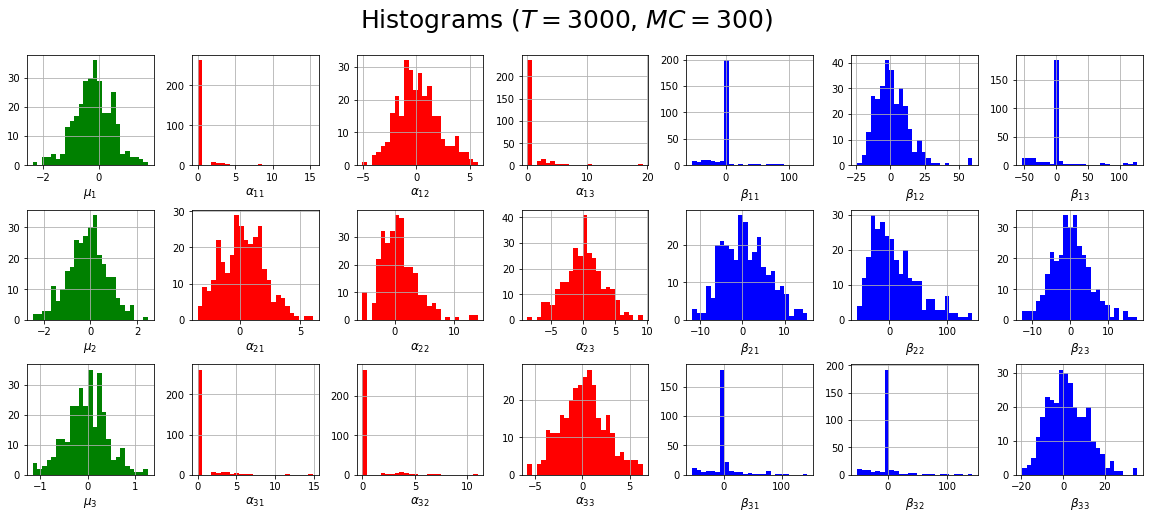

In [14]:
title = r'Histograms ($T=%d$, $MC=%d$)' %(t_max, MC)
SavePath = 'POE/ver3modi_HPPOE_eg1_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(poeErrorList, dims, title, SavePath)